# Model Creation

In this notebook, we will process the data and train our final model to classify cancellations.


---

**Dependencies**

Check `requirements.txt`

Main:
* ipykernel
* pandas
* sckit-learn
* azureml-sdk
* xgboost

### Libraries

In [44]:
import pickle

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    classification_report,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

### Load data

In [45]:
%load_ext kedro.ipython

The kedro.ipython extension is already loaded. To reload it, use:
  %reload_ext kedro.ipython


In [46]:
%reload_kedro

[01/06/2025 03:45:50 a. m.] INFO     Resolved project path as: C:\Users\Esteban\Documents\.         __init__.py:180
                                     Clases_Tec\8. Octavo semestre\_Proyecto\kProject\tcaproject.                  
                                     To set a different path, run '%reload_kedro <project_root>'                   

[01/06/2025 03:45:51 a. m.] INFO     Registering new custom resolver: 'km.random_name'            mlflow_hook.py:65

                            WARNING  No 'mlflow.yml' config file found in environment. Default    mlflow_hook.py:78
                                     configuration will be used. Use ``kedro mlflow init``                         
                                     command in CLI to customize the configuration.                                

                            INFO     Kedro is sending anonymous usage data with the sole purpose of   plugin.py:233
                                     improving the product. No personal data or IP addresses are                   
                                     stored on our side. If you want to opt out, set the                           
                                     `KEDRO_DISABLE_TELEMETRY` or `DO_NOT_TRACK` environment                       
                                     variables, or create a `.telemetry` file in the current working               
                                     directory with the contents `consent: false`. Read more at                    
                                     https://docs.kedro.org/en/stable/configuration/telemetry.html                 

[01/06/2025 03:45:53 a. m.] INFO     Kedro project tcaProject                                       __init__.py:146

                            INFO     Defined global variable 'context', 'session', 'catalog' and    __init__.py:147
                                     'pipelines'                                                                   

                            INFO     Registered line magic 'run_viz'                                __init__.py:153

In [47]:
df = catalog.load("reservaciones_cleaned")  # type: ignore # noqa: F821
df.shape

                            INFO     Loading data from reservaciones_cleaned                    data_catalog.py:403
                                     (ParquetDataset)...                                                           

(202491, 49)

In [48]:
df.nombre_paquete.value_counts().index

Index(['Walk In', 'Ninguno', 'Entre Semana', 'Lunamielero', 'Fin De Semana'], dtype='object', name='nombre_paquete')

In [49]:
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 202491 entries, 0 to 203001
Columns: 49 entries, id_reservaciones to cliente_disp_anio_anterior
dtypes: bool(3), datetime64[ns](5), float64(2), int64(24), object(15)
memory usage: 73.2+ MB


In [50]:
df.head()

,id_reservaciones,fecha_hoy,fecha_reservacion,fecha_llegada,fecha_salida,numero_personas,numero_personas_anio_anterior,numero_adultos,numero_adultos_anio_anterior,numero_menores,...,nombre_estatus_reservacion,clave_estado,nombre_estado,total_tarifa,id_moneda,fecha_ultimo_cambio,reservacion,reservacion_anio_anterior,id_cliente_disp,cliente_disp_anio_anterior
0,0,2019-08-16,2019-08-16,2019-07-11,2019-10-11,2,0,2,0,0,...,Salida,Emx,Mexico,2659.98,1,2019-10-11,True,False,2,0
1,1,2019-10-22,2019-10-22,2019-01-12,2019-05-12,4,0,4,0,0,...,Salida,Egt,Guanajuato,1764.00,1,2019-05-12,True,False,4,0
2,2,2019-10-28,2019-10-28,2019-01-12,2019-05-12,2,0,2,0,0,...,Salida,Emc,Michoacan,2660.04,1,2019-05-12,True,False,2,0
3,3,2019-10-28,2019-10-28,2019-08-12,2019-11-12,4,0,3,0,0,...,Salida,Egt,Guanajuato,1995.03,1,2019-11-12,True,False,3,0
4,4,2019-10-28,2019-10-28,2019-08-12,2019-12-12,2,0,2,0,0,...,Salida,Emx,Mexico,13369.92,1,2019-12-12,True,False,2,0


### Data Processing

#### 0. Target Variable

Definition of target varable (cancelacion)

In [51]:
df_tv = df.copy() # Copy of last dataset

df_tv['cancelacion'] = df_tv["nombre_estatus_reservacion"].apply(lambda x: 1 if x == 'Reservacion Cancelada' else 0)

# Value counts of target variable
df_tv['cancelacion'].value_counts()


cancelacion
0    169194
1     33297
Name: count, dtype: int64

#### 1. Filter variables

Filter the variables that will be used by the model.

In [52]:
model_variables =['nombre_paquete',
                  'ciudad_agencia',
                  'nombre_tipo_habitacion',
                  'nombre_canal',
                  'nombre_estado',
                  #'hist_menores',
                  #'hist_total_habitaciones'
                  ]

# Model variables and target variable
df_fv = df_tv.copy()[model_variables+['cancelacion']]

df_fv.head()

,nombre_paquete,ciudad_agencia,nombre_tipo_habitacion,nombre_canal,nombre_estado,cancelacion
0,Walk In,Mexico City,Estd 2Q Sn12Mst,Multivacaciones 2,Mexico,0
1,Ninguno,Mexico City,Estd 2Q Sn12Mst,Multivacaciones 2,Guanajuato,0
2,Walk In,Mexico City,Jr Suite 1K Sn12Mjs,Multivacaciones 2,Michoacan,0
3,Ninguno,Mexico City,Jr Suite 2Q Sn12Mjs,Multivacaciones 2,Guanajuato,0
4,Walk In,Cancun,Luxury 2Q Sn12Gsu,Vertical Booking,Mexico,0


#### 2. Clean spaces

In [53]:
def clean_spaces(obj):
    if isinstance(obj, dict):
        return {k: clean_spaces(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [clean_spaces(elem) for elem in obj]
    elif isinstance(obj, pd.Series):
        return obj.apply(clean_spaces)
    elif isinstance(obj, pd.DataFrame):
        return obj.map(clean_spaces)
    elif isinstance(obj, str):
        return ' '.join(obj.split())
    else:
        return obj

In [54]:
df_cs = df_fv.copy()
df_cs = clean_spaces(df_cs)
df_cs.nombre_paquete.value_counts().index

Index(['Walk In', 'Ninguno', 'Entre Semana', 'Lunamielero', 'Fin De Semana'], dtype='object', name='nombre_paquete')

#### 3. Transform categorical variables

In [55]:
df_tcv = df_cs.copy()

# Subset of dataset containing only records with canceled reservations
df_cancelations = df_tcv[df_tcv.cancelacion == 1]


# Function
def calcular_peso_columna(dfx, columna, nombre_columna_resultado=None):
    # Usar nombre_columna_resultado o columna si no se especifica
    nombre_columna_resultado = nombre_columna_resultado or columna

    # Calcular conteos de valores únicos (convertidos a string para evitar problemas con tipos mixtos)
    conteos = dfx[columna].astype(str).value_counts()

    # Crear DataFrame resultado directamente desde la Serie conteos
    peso = conteos.rename_axis(nombre_columna_resultado).reset_index(name='conteo')

    # Calcular proporción en porcentaje con 3 decimales
    peso['proporcion'] = (peso['conteo'] / peso['conteo'].sum()).round(4)

    return peso


# Diccionario con pesos para cada columna, limpiando '#_' del nombre para la clave
pesos = {
    f"peso_{col}": calcular_peso_columna(dfx=df_cancelations, columna=col)
    for col in model_variables
}

# Convertir pesos a diccionario json
dict_pesos = {k: v.to_dict(orient='records') for k, v in pesos.items()}


# Reemplaza los valores en el df con los pesos asignados a cada variable del diccionario
for col in model_variables:
    nombre_peso = f"peso_{col}"

    if nombre_peso in pesos:
        # Mapear valores directamente usando Series para mejor rendimiento
        #mapa = pesos[nombre_peso].set_index(col)['proporcion']
        mapa = pd.Series({item[col]: item['proporcion'] for item in dict_pesos[nombre_peso]})
        df_tcv[col] = df_tcv[col].astype(str).map(mapa)


df_tcv.head()

,nombre_paquete,ciudad_agencia,nombre_tipo_habitacion,nombre_canal,nombre_estado,cancelacion
0,0.8825,0.3008,0.0899,0.1630,0.0689,0
1,0.1174,0.3008,0.0899,0.1630,0.0331,0
2,0.8825,0.3008,0.0489,0.1630,0.0812,0
3,0.1174,0.3008,0.0240,0.1630,0.0331,0
4,0.8825,0.1750,0.2974,0.0184,0.0689,0


**Save dict_pesos as json**

In [56]:
# save dict_json as json file with asci encoding in thi s notebook folder
with open("pesos_variables.json", "w", encoding="utf-8") as f:
    import json
    json.dump(dict_pesos, f, ensure_ascii=False, indent=4)


**Test read dict_pesos json file and update categorical columns for testing**

In [57]:
# Test read dict_pesos json file and update categorical columns for testing
with open('pesos_variables.json') as f:
    dict_pesos = json.load(f)

# Test dataset
df_json_test = df_fv.copy()


# Update categorical columns in df_tcv with the weights from dict_pesos
for col in model_variables:
    col_name = "peso_"+col
    if col_name in dict_pesos:
        # Mapear valores directamente usando Series para mejor rendimiento
        mapa = pd.Series({item[col]: item['proporcion'] for item in dict_pesos[col_name]})
        df_json_test[col] = df_json_test[col].astype(str).map(mapa)

df_json_test.fillna(0, inplace=True)  # Fill NaN values with 0

df_json_test.head()

,nombre_paquete,ciudad_agencia,nombre_tipo_habitacion,nombre_canal,nombre_estado,cancelacion
0,0.8825,0.3008,0.0899,0.1630,0.0689,0
1,0.1174,0.3008,0.0899,0.1630,0.0331,0
2,0.8825,0.3008,0.0489,0.1630,0.0812,0
3,0.1174,0.3008,0.0240,0.1630,0.0331,0
4,0.8825,0.1750,0.2974,0.0184,0.0689,0


*df_cancelations don't have all the values that has df_tcv; this "label encoding" may fail*

### Model

In [58]:
df_model = df_tcv.copy()

df_model.dropna(axis=0, inplace=True)
df_model.isna().sum().sum()

np.int64(0)

**Split variables**

In [59]:
X = df_model[model_variables]
y = df_model["cancelacion"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(159850, 5)
(159850,)
(39963, 5)
(39963,)


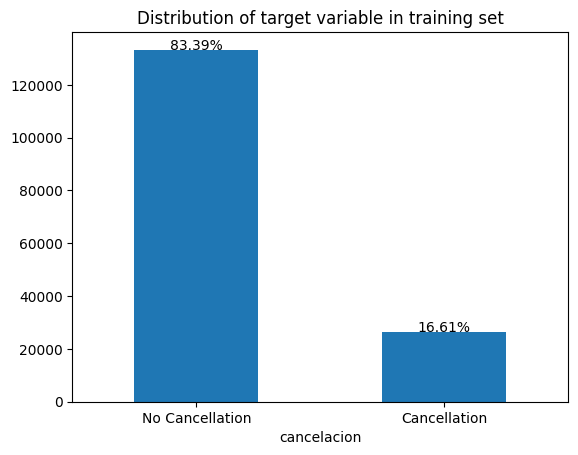

In [60]:
y_train.value_counts().plot.bar()
plt.title("Distribution of target variable in training set")
plt.xticks([0, 1], ['No Cancellation', 'Cancellation'], rotation=0)
# add the number in percentage on top of the bars
for i, v in enumerate(y_train.value_counts()):
    plt.text(i, v + 10, f"{v / len(y_train) * 100:.2f}%", ha='center')
plt.show()

**Train and evaluate**

In [61]:
# Entrenar el modelo
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=(len(y_train[y_train == 0]) / len(y_train[y_train == 1])),
    #use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train, y_train);

**scale_pos_weight**

* Multiplies the gradients (errors) of the positive class by the scale_pos_weight value.
* This gives errors in the positive class greater weight during optimization, incentivizing the model to correct them more aggressively.

### Evaluation

In [62]:
y_pred = xgb_model.predict(X_test)

print(classification_report(y_test, y_pred, target_names=['No Cancellation', 'Cancellation']))

                 precision    recall  f1-score   support

No Cancellation       0.97      0.89      0.93     33219
   Cancellation       0.63      0.88      0.73      6744

       accuracy                           0.89     39963
      macro avg       0.80      0.89      0.83     39963
   weighted avg       0.91      0.89      0.90     39963



**Classification Report**
* **Precision:** Proportion of correct positive predictions over all positive predictions. -> Of all the customers the model predicted would cancel, how many actually canceled. High precision means few false alarms.
* **Recall:** Proportion of correctly detected positive cases. -> Of all the customers who actually canceled, how many did the model detect. High recall means few false negatives (not missing real cancellations).
* **F1-Score:** Harmonic mean of precision and recall, balancing the two.
-> Useful metric when you want a balance between precision and recall.
* **Support:** Number of real examples of each class in the test set.
* **accuracy:** Total percentage of correct predictions.
* **macro avg:** Unweighted average of the per-class metrics (0 and 1).
* **weighted avg:** Weighted average by the support (number of examples) of each class.

---

Interpretation of our ressults

Class 0 (No Cancellations):

* Precision (0.97): Of all "Did Not Cancel" predictions, 97% were correct. Very few false alarms.
* Recall (0.89): Detected 89% of actual "Did Not Cancel" cases. 11% were missed (false negatives).
* F1-Score (0.93): Excellent balance between precision and recall.

Class 1 (Cancellations):
* Precision (0.63): Of the "Canceled" predictions, only 63% were correct. Many false alarms (FP).
* Recall (0.88): **Detected 88% of actual cancellations.** Good performance in identifying positive cases.
* F1-Score (0.73): Acceptable balance, but limited by low precision.

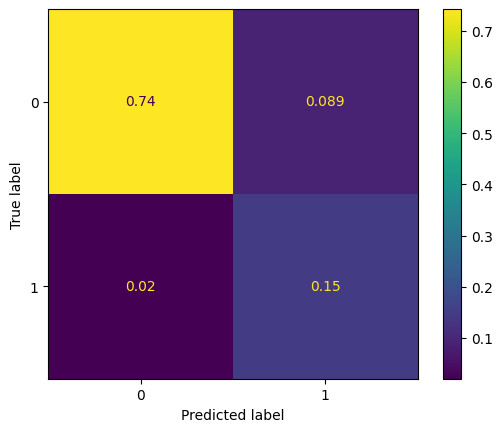

In [63]:
ConfusionMatrixDisplay.from_estimator(xgb_model, X_test, y_test, normalize='all');

**Confussion Matrix**
* You want to minimize FN so you don't lose customers who actually cancel.
* You also want to monitor FP so you don't generate unnecessary alerts.

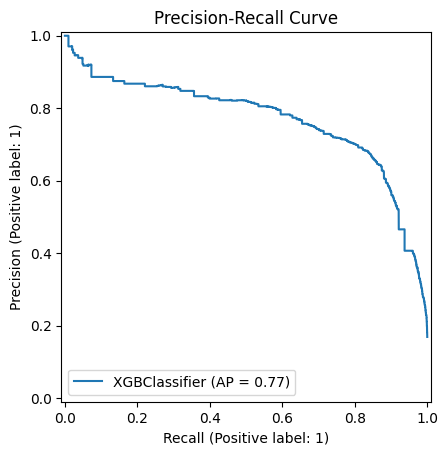

In [64]:
PrecisionRecallDisplay.from_estimator(xgb_model, X_test, y_test)
plt.title("Precision-Recall Curve")
plt.show()

**AUC-PR Curve (Area Under the Precision-Recall Curve)**

[AUC PR Curve](https://medium.com/bluekiri/curvas-pr-y-roc-1489fbd9a527)

Shows the relationship between precision and recall for different model decision thresholds.
It is more informative than the ROC curve when the classes are unbalanced (as in your case with 80% non-cancellations).
* A curve that remains high in precision for high recall values ​​indicates a good model.

The PR curve is the result of plotting the graph between precision and recall. This graph allows us to see where the precision declines from the recall level and vice versa. Ideally, the curve should be as close as possible to the upper right corner (high precision and high recall).

---

Interpretation of our results

* A gradual drop in precision as recall increases.
* AUC-PR between 0.7 and 0.8 (good for unbalanced classes, but could be improved).

* The classification report tells you how well the model predicts each class using key metrics.
* The confusion matrix shows you the specific successes and errors for each class.
* The AUC-PR curve helps you evaluate overall performance in unbalanced scenarios and choose the best decision threshold.

**Save model**

Picke format.

In [65]:
with open('xgboost_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

---
